In [ ]:
!pip install scikit-plot

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import scikitplot

from sklearn.metrics import roc_curve, auc

In [ ]:
dataDir = '/content/drive/My Drive/COVID19-Mixed/Images'

def Read_Images_and_Make_Numpy_Files():
  images = []
  labels = []
  classes = os.listdir(dataDir)
  print('Classes: {}'.format(classes))
  for class_ in classes:
    if class_ == '0:Normal':
      print('Reading Data for {} class'.format(class_))
      imageNames = os.listdir(os.path.join(dataDir, class_))
      for imgName in tqdm(imageNames):
        img = load_img(os.path.join(dataDir, class_, imgName), target_size=(224, 224), color_mode='rgb', interpolation='lanczos')
        img_array = img_to_array(img, data_format='channels_last', dtype='float32')
        images.append(img_array)
        labels.append(0)
    elif class_ == '1:COVID19':
      print('Reading Data for {} class'.format(class_))
      imageNames = os.listdir(os.path.join(dataDir, class_))
      for imgName in tqdm(imageNames):
        img = load_img(os.path.join(dataDir, class_, imgName), target_size=(224, 224), color_mode='rgb', interpolation='lanczos')
        img_array = img_to_array(img, data_format='channels_last', dtype='float32')
        images.append(img_array)
        labels.append(1)
  
  images = np.array(images).reshape(-1, 224, 224, 3)
  print('Images: {}'.format(images.shape))
  labels = np.array(labels)
  print('Labels: {}'.format(labels.shape))
  np.save('/content/drive/My Drive/COVID19-Mixed/Images', images)
  np.save('/content/drive/My Drive/COVID19-Mixed/labels', labels)


Read_Images_and_Make_Numpy_Files()

Classes: ['0:Normal', '1:COVID19']
Reading Data for 0:Normal class



Reading Data for 1:COVID19 class



Images: (2581, 224, 224, 3)
Labels: (2581,)


In [ ]:
dataDir = '/content/drive/My Drive/COVID19-Mixed'
x = np.load('/content/drive/My Drive/COVID19-Mixed/Images.npy')
y = np.load('/content/drive/My Drive/COVID19-Mixed/labels.npy')

print('Images: {} | Labels: {}'.format(x.shape, y.shape))

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.15, random_state=2020)
print('Training Images: {} | Test Images: {}'.format(train_x.shape, test_x.shape))
print('Training Labels: {} | Test Labels: {}'.format(train_y.shape, test_y.shape))

# Data Normalization

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

train_x/=255
test_x/=255

print('Train: {} , {} | Test: {} , {}'.format(train_x.min(), train_x.max(), test_x.min(), test_x.max()))

Images: (2581, 224, 224, 3) | Labels: (2581,)
Training Images: (2193, 224, 224, 3) | Test Images: (388, 224, 224, 3)
Training Labels: (2193,) | Test Labels: (388,)
Train: 0.0 , 255.0 | Test: 0.0 , 255.0
Train: 0.0 , 1.0 | Test: 0.0 , 1.0


In [ ]:
# Class Mapping 
print('0:Normal | 1:COVID-19')

# Distribution of images in each class for Training-set
print(Counter(train_y))

# Distribution of images in each class for Test-set
print(Counter(test_y))

#Make Labels Categorical
train_y_oneHot = tf.one_hot(train_y, depth=2) 
test_y_oneHot = tf.one_hot(test_y, depth=2)

print('Training Labels: {} | Test Labels: {}'.format(train_y_oneHot.shape, test_y_oneHot.shape))

0:Normal | 1:COVID-19
Counter({1: 1136, 0: 1057})
Counter({1: 216, 0: 172})
Training Labels: (2193, 2) | Test Labels: (388, 2)


In [ ]:

trainAug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,
                                                           width_shift_range=0.2,         # Range for random horizontal shifts,
                                                           height_shift_range=0.2,        # Range for random vertical shifts
                                                           zoom_range=0.2,                # Range for random zoom
                                                           horizontal_flip=True,          # Randomly flip inputs horizontally
                                                           vertical_flip=True,            # Randomly flip inputs vertically
                                                           fill_mode="nearest")

def DenseNet121_Model():
  # load the DenseNet169 network, ensuring the head FC layer sets are left off
  baseModel = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling=None)
  # construct the head of the model that will be placed on top of the the base model
  output = baseModel.output
  output = tf.keras.layers.GlobalAveragePooling2D()(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output = tf.keras.layers.Dense(1024, activation="relu")(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(512, activation="relu")(output)
  output = tf.keras.layers.BatchNormalization()(output)
  output = tf.keras.layers.Dropout(0.5)(output)
  output = tf.keras.layers.Dense(2, activation="softmax")(output)
  # place the head FC model on top of the base model (this will become the actual model we will train)
  model = tf.keras.Model(inputs=baseModel.input, outputs=output)
  # loop over all layers in the base model and freeze them so they will not be updated during the first training process
  for layer in baseModel.layers:
    layer.trainable = False
  return model

model = DenseNet121_Model()
# compile our model
print("[INFO] compiling model...")
# initialize the initial learning rate, number of epochs to train for, and batch size
EPOCHS = 50
BATCHSIZE = 32 
optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
print(model.summary())

29089792/29084464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]              

In [ ]:
modelPath = '/content/drive/My Drive/BTP Project/DenseNet121'
if not os.path.exists(modelPath):
  os.makedirs(modelPath)
  print('Model Directory Created')
else:
  print('Model Directory Already Exists')

annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, verbose=1, min_lr=1e-3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(modelPath+'/denseNet121-best-model.h5', monitor='val_categorical_accuracy',
                                                      verbose=1, save_best_only=True, mode='auto')

STEP_TRAIN = len(train_x) // BATCHSIZE
STEP_TEST = len(test_x) // BATCHSIZE
modelHistory = model.fit(trainAug.flow(train_x, train_y_oneHot, batch_size=BATCHSIZE), epochs=EPOCHS, verbose=1, callbacks=[model_checkpoint],
                         validation_data=(test_x, test_y_oneHot), shuffle = True, steps_per_epoch=STEP_TRAIN, validation_steps=STEP_TEST)
tf.keras.models.save_model(model, modelPath+'/denseNet121-model.h5', overwrite=True, include_optimizer=True, save_format=None,
                           signatures=None, options=None)

Model Directory Already Exists
Epoch 1/50
68/68 [==============================] - ETA: 0s - loss: 0.9808 - categorical_accuracy: 0.6030 - auc: 0.6470
Epoch 00001: val_categorical_accuracy improved from -inf to 0.66495, saving model to /content/drive/My Drive/BTP Project/DenseNet121/denseNet121-best-model.h5
68/68 [==============================] - 389s 6s/step - loss: 0.9808 - categorical_accuracy: 0.6030 - auc: 0.6470 - val_loss: 0.5584 - val_categorical_accuracy: 0.6649 - val_auc: 0.7657
Epoch 2/50
68/68 [==============================] - ETA: 0s - loss: 0.6942 - categorical_accuracy: 0.7131 - auc: 0.7935
Epoch 00002: val_categorical_accuracy improved from 0.66495 to 0.70619, saving model to /content/drive/My Drive/BTP Project/DenseNet121/denseNet121-best-model.h5
68/68 [==============================] - 390s 6s/step - loss: 0.6942 - categorical_accuracy: 0.7131 - auc: 0.7935 - val_loss: 0.5119 - val_categorical_accuracy: 0.7062 - val_auc: 0.8112
Epoch 3/50
68/68 [==================

In [ ]:
# Evaluate the Best Saved Model
model = tf.keras.models.load_model('/content/drive/My Drive/BTP Project/DenseNet121/denseNet121-best-model.h5')
loss, accuracy, auc = model.evaluate(x=test_x, y=test_y_oneHot, batch_size=32, verbose=1)
print('Model Accuracy: {:0.2f} | Model AUC: {:0.2f} | Model Loss: {:0.4f}'.format(accuracy, auc, loss))

13/13 [==============================] - 49s 4s/step - loss: 0.2539 - categorical_accuracy: 0.8840 - auc: 0.9611
Model Accuracy: 0.88 | Model AUC: 0.96 | Model Loss: 0.2539


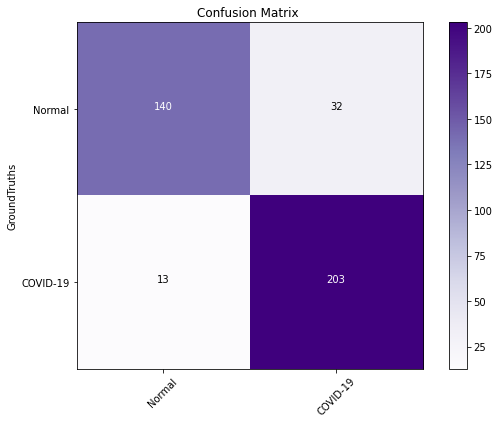

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Purples')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
      plt.text(j, i, "{:0.4f}".format(cm[i, j]),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")
    else:
      plt.text(j, i, "{:,}".format(cm[i, j]),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('GroundTruths')
  #plt.xlabel('Predictions \n Model Accuracy={:0.2f}% | Model Error={:0.2f}%'.format(accuracy*100, misclass*100))
  plt.savefig('/content/drive/My Drive/BTP Project/DenseNet121/denseNet121-cm-1.png', bbox_inches = "tight")
  plt.show()


predictions = model.predict(x=test_x, batch_size=32)
predictions = tf.keras.backend.argmax(predictions, axis=-1)

cm = confusion_matrix(test_y, predictions)
classes = ['Normal', 'COVID-19']
plot_confusion_matrix(cm=cm, normalize = False, target_names = classes, title= "Confusion Matrix ")

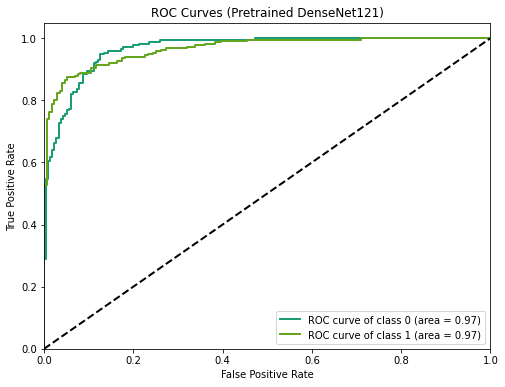

In [ ]:
#Plot ROC Curve with Library
predictions = model.predict(x=test_x, batch_size=32)
# One can define colormap here
# cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan'])
scikitplot.metrics.plot_roc(y_true=test_y, y_probas=predictions, title='ROC Curves (Pretrained DenseNet121)', plot_micro=False, plot_macro=False,
                            classes_to_plot=None, ax=None, figsize=(8, 6), cmap='Dark2', title_fontsize='large', text_fontsize='medium')
plt.savefig('/content/drive/My Drive/BTP Project/DenseNet121/denseNet121-roc.png', bbox_inches = "tight")
plt.show()

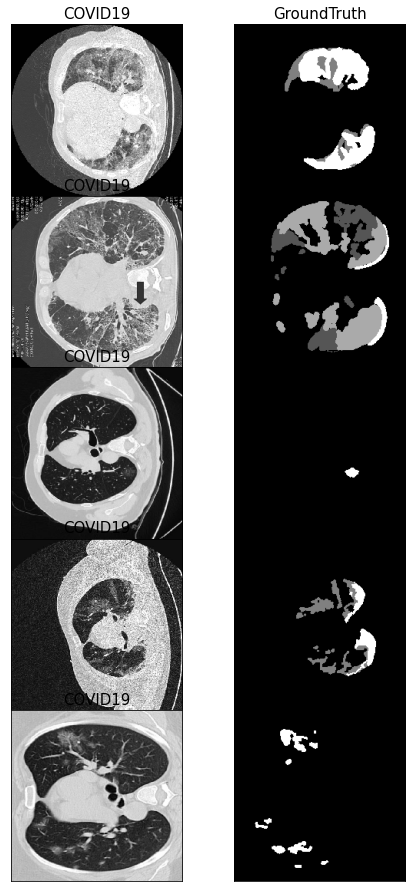

In [ ]:
dataDir = '/content/drive/My Drive/COVID19-Mixed/Masks/1:COVID19 Masks'

def rotateImage(img, rotateDegree):
    return img.rotate(rotateDegree, expand=1)

def ReadImage(imgPath):
  img = tf.keras.preprocessing.image.load_img(imgPath, target_size=(224, 224))
  # img = rotateImage(img, 90)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.float32)
  img = img/255
  return img

maskNames = os.listdir(dataDir)
covid19 = []
covid19_gt = []
for maskName in maskNames[:10]:
  imagePath = '/content/drive/My Drive/COVID19-Mixed/Images/1:COVID19/'+maskName
  covid19.append(ReadImage(imagePath))
  
  maskPath = dataDir+'/'+maskName
  covid19_gt.append(ReadImage(maskPath))
  
covid19 = np.array(covid19).reshape(-1, 224, 224, 3)
covid19_gt = np.array(covid19_gt).reshape(-1, 224, 224, 3)

titles = ['COVID19', 'GroundTruth']
rows = 5
cols = 2
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(6.5, 12.5), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot COVID19 image
  ax[r][0].imshow(covid19[r, :, :, :])
  ax[r][0].set_title(titles[0], fontsize=15)
   # plot Ground Truth
  ax[r][1].imshow(covid19_gt[r, :, :, :])
  ax[r][1].set_title(titles[1], fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

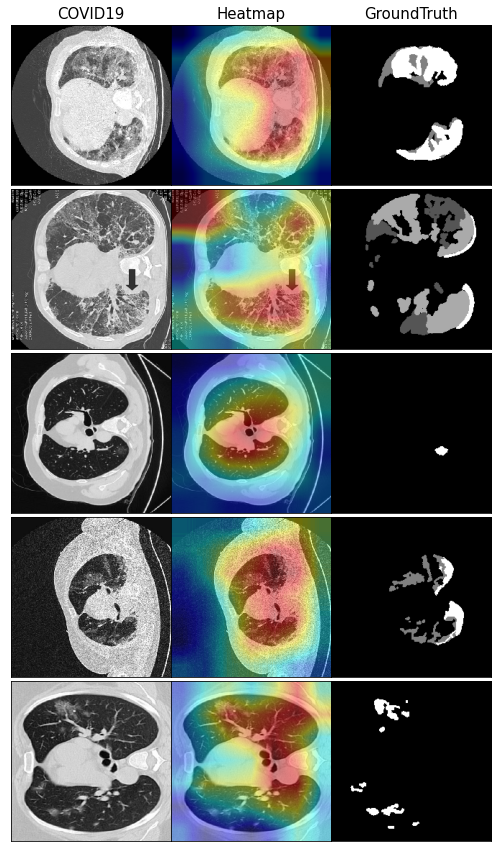

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

LAYER_NAME = 'relu'
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

def GetHeatMap(img):
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    # print(np.argmax(predictions))
    loss = predictions[:, np.argmax(predictions)]

  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]

  gate_f = tf.cast(output > 0, 'float32')
  gate_r = tf.cast(grads > 0, 'float32')
  guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

  weights = tf.reduce_mean(guided_grads, axis=(0, 1))

  cam = np.ones(output.shape[0: 2], dtype = np.float32)

  for i, w in enumerate(weights):
      cam += w * output[:, :, i]

  cam = cv2.resize(cam.numpy(), (224, 224))
  cam = np.maximum(cam, 0)
  cam = (cam - cam.min()) / (cam.max() - cam.min())
  cam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

  heatmap = cv2.addWeighted(np.uint8(255*img), 0.6, cam, 0.4, 0)
  return heatmap

titles = ['COVID19', 'Heatmap', 'GroundTruth']
rows = 5
cols = 3

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(7, 12), subplot_kw={'xticks': [], 'yticks': []})
for r in range(rows):
  # plot COVID19 image
  ax[r][0].imshow(covid19[r, :, :, :])
  if r==0:
    ax[r][0].set_title(titles[0], fontsize=15)
  
  # plot COVID19 heatmap
  ax[r][1].imshow(covid19[r, :, :, :])
  ax[r][1].imshow(GetHeatMap(covid19[r, :, :, :]))
  if r==0:
    ax[r][1].set_title(titles[1], fontsize=15)
  
  # plot COVID19 Groud-Truth
  ax[r][2].imshow(covid19_gt[r, :, :, :])
  if r==0:
    ax[r][2].set_title(titles[2], fontsize=15)


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('/content/drive/My Drive/BTP Project/DenseNet121/densenet121-visualization.png')
plt.show()
plt.close()